In [23]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.activations import relu
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, LeakyReLU, Dense, Input, Concatenate, Activation, LeakyReLU

## Utils

In [2]:
def show_img(image, title=""):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{title}")
    plt.show()
    
def apply_kernel(image: np.array, kernel: np.array):
    # edges = cv2.filter2D(src=image, cv2.CV_64F, kernel=kernel)
    edges = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    img_edges = np.uint8(np.absolute(edges))  # make to unsigned 8 bit int
    return img_edges

## Load Data

In [3]:
datapath = "./data.csv"
df = pd.read_csv(datapath)
df.head()

,filepath,filename,target,class
0,./data/desert/desert(1017).jpg,desert(1017).jpg,3,desert
1,./data/green_area/Forest_610.jpg,Forest_610.jpg,2,green_area
2,./data/desert/desert(1087).jpg,desert(1087).jpg,3,desert
3,./data/cloudy/train_2904.jpg,train_2904.jpg,0,cloudy
4,./data/cloudy/train_6891.jpg,train_6891.jpg,0,cloudy


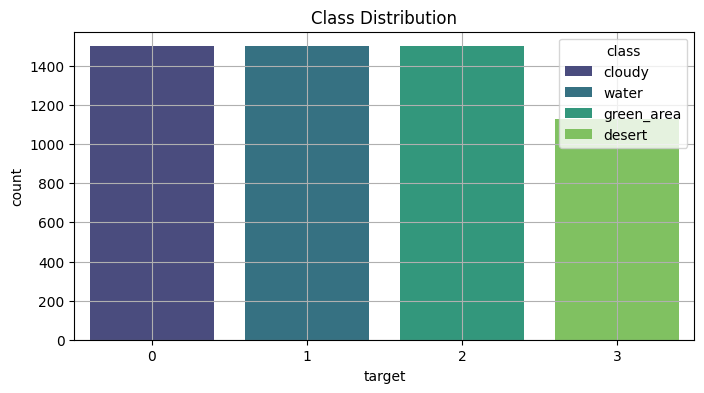

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="target", palette="viridis", hue='class')
plt.title("Class Distribution")
plt.grid(True)
plt.show()

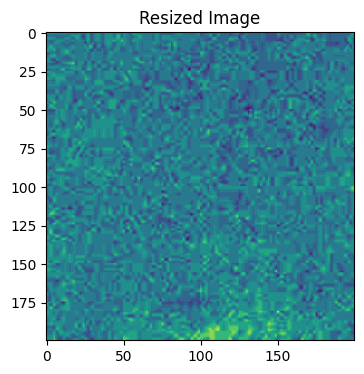

In [5]:
data = df['filepath'].values
images: list = list()

for ip in data:
    image = cv2.imread(ip, 0)
    dims = (200, 200)
    image = cv2.resize(image, dims, interpolation=cv2.INTER_AREA)
    images.append(image)

show_img(images[0], "Resized Image")

## Feature Extraction

#### Gabor Filter

In [6]:
# ksize = 11
# sigma = 4.0
# theta = np.pi/4
# lambd = 10.0
# gamma = 0.5
# psi = 0

# gabor_kernel = cv2.getGaborKernel( (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F )
# plt.imshow(gabor_kernel)
# plt.show()

In [7]:
# f_image = cv2.filter2D(src=image, ddepth=-1, kernel=gabor_kernel )
# f_image[: 6, : 6]

#### laplacian_kernel

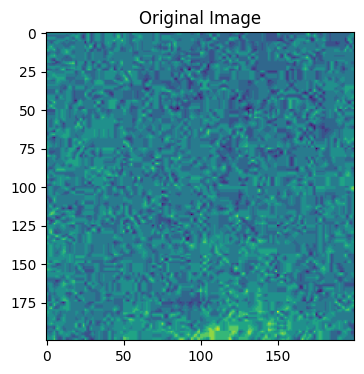

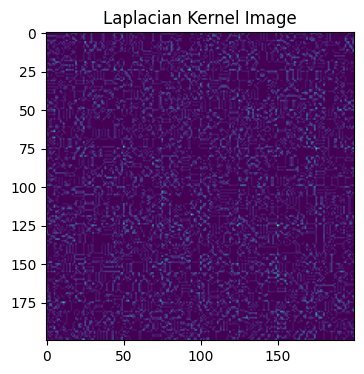

In [8]:
filter_imgs : list = list()
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
# 
for image in images:
    lk_img = apply_kernel(image, laplacian_kernel)
    filter_imgs.append(lk_img)
filter_imgs = np.array(filter_imgs)
show_img(images[0], "Original Image")
show_img(filter_imgs[0], "Laplacian Kernel Image")

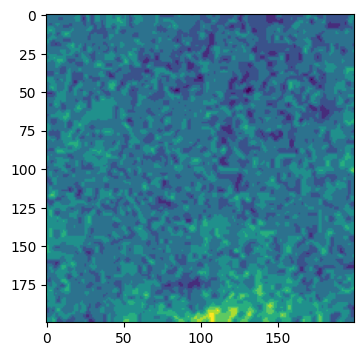

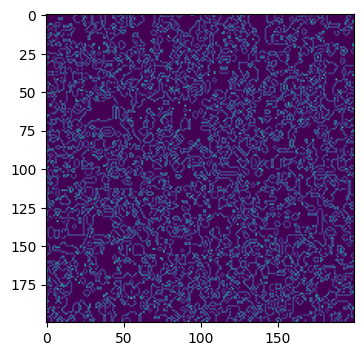

In [9]:
# Gaussian smoothing
gs_dims = (5, 5)
blurred_img = cv2.GaussianBlur(images[0], gs_dims, 0)
show_img(blurred_img)
show_img(apply_kernel(blurred_img, laplacian_kernel))

## Data Split And Normalisation

In [10]:
filter_imgs = filter_imgs / 255.0

In [11]:
x_train, x_test, y_train, y_test  = train_test_split(filter_imgs, df['target'], test_size=0.3, random_state=18 ) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3941, 200, 200), (1690, 200, 200), (3941,), (1690,))

## Train

#### LSTM

In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_train.shape

(3941, 4)

In [13]:
x_train.shape, y_train.shape

((3941, 200, 200), (3941, 4))

In [14]:
BATCH_SIZE = 16
DROPOUT_RATE = 0.4
LEARNING_RATE: int = 0.1e-3
INPUT_SHAPE = filter_imgs.shape[1:]
NUM_CLASSES = y_train.shape[-1]

#
input1 = Input(shape=(INPUT_SHAPE), name="first lstm input layer")
x1 = LSTM(64, return_sequences=True)(input1)
x1 = LSTM(32, return_sequences=True)(x1)
x1 = LSTM(16)(x1)
# 
x1 = Dense(64, activation='LeakyReLU', activity_regularizer=l2(LEARNING_RATE))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(DROPOUT_RATE)(x1)

output = Dense(NUM_CLASSES, activation="softmax")(x1)
# 
model = Model(inputs=input1, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

# keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True, show_trainable=True )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first lstm input layer (In  [(None, 200, 200)]        0         
 putLayer)                                                       
                                                                 
 lstm (LSTM)                 (None, 200, 64)           67840     
                                                                 
 lstm_1 (LSTM)               (None, 200, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                              

In [15]:
EPOCHS = 10
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2 )

Epoch 1/10
197/197 - 18s - loss: 0.7880 - accuracy: 0.6751 - val_loss: 0.7982 - val_accuracy: 0.7465 - 18s/epoch - 93ms/step
Epoch 2/10
197/197 - 15s - loss: 0.3198 - accuracy: 0.8871 - val_loss: 0.3234 - val_accuracy: 0.8682 - 15s/epoch - 78ms/step
Epoch 3/10
197/197 - 15s - loss: 0.2516 - accuracy: 0.9153 - val_loss: 1.8235 - val_accuracy: 0.5323 - 15s/epoch - 78ms/step
Epoch 4/10
197/197 - 15s - loss: 0.2159 - accuracy: 0.9251 - val_loss: 0.3253 - val_accuracy: 0.8872 - 15s/epoch - 78ms/step
Epoch 5/10
197/197 - 15s - loss: 0.2319 - accuracy: 0.9175 - val_loss: 0.5562 - val_accuracy: 0.7997 - 15s/epoch - 77ms/step
Epoch 6/10
197/197 - 15s - loss: 0.1765 - accuracy: 0.9416 - val_loss: 0.3998 - val_accuracy: 0.9062 - 15s/epoch - 78ms/step
Epoch 7/10
197/197 - 17s - loss: 0.2158 - accuracy: 0.9185 - val_loss: 0.4252 - val_accuracy: 0.8023 - 17s/epoch - 84ms/step
Epoch 8/10
197/197 - 17s - loss: 0.1480 - accuracy: 0.9470 - val_loss: 0.3883 - val_accuracy: 0.8390 - 17s/epoch - 87ms/step


#### Save Model To File

In [ ]:
# model.save("./models/laplacian_model.keras")

## Evaluate

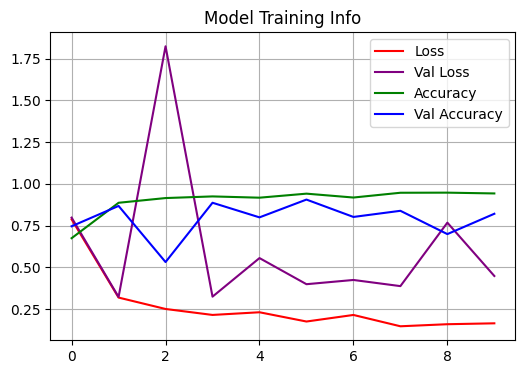

In [30]:
s = model_history.history

plt.figure(figsize=(6, 4))
plt.plot(s['loss'], label="Loss", color="red")
plt.plot(s['val_loss'], label="Val Loss", color="purple" )
plt.plot(s['accuracy'], label="Accuracy", color="green" )
plt.plot(s['val_accuracy'], label="Val Accuracy", color="blue" )
plt.title("Model Training Info")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_preds

53/53 [==============================] - 2s 38ms/step


array([0, 3, 2, ..., 3, 0, 2])

In [20]:
accuracy_score(y_test, y_preds)

0.8254437869822485

In [22]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       432
           1       1.00      0.54      0.70       469
           2       0.70      1.00      0.83       442
           3       1.00      0.77      0.87       347

    accuracy                           0.83      1690
   macro avg       0.87      0.83      0.82      1690
weighted avg       0.87      0.83      0.82      1690



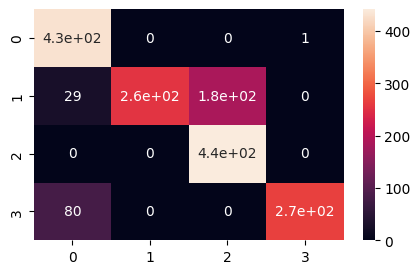

In [27]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.show()